In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from cgpdm import CGPDM
from dataset_utils.mocap_labels import WALK_TRIALS_TRAIN, WALK_TRIALS_TEST, RUN_TRIALS_TRAIN, RUN_TRIALS_TEST
import dataset_utils.select_joints as select_joints

In [15]:
gpdm_save_name = "cgpdm"

In [16]:
reduced_columns = WALK_TRIALS_TRAIN[0].get_columns_for_joints(select_joints.WALKING_SIMPLIFIED_JOINTS)
DOFs = len(reduced_columns)
print(f"Number of DOFs: {DOFs}")


Number of DOFs: 35


In [17]:
walk_train_dfs = [trial.as_dataframe() for trial in WALK_TRIALS_TRAIN]
walk_train_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::5, :] for df in walk_train_dfs]

run_train_dfs = [trial.as_dataframe() for trial in RUN_TRIALS_TRAIN]
run_train_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::5, :] for df in run_train_dfs]


In [18]:
d = 3 # latent space dimension
DOFs = len(reduced_columns)  # number of degrees of freedom

dyn_back_step = 1 # Number of time steps to look back in the dynamics GP

# Initial values for hyperparameters
y_lambdas_init = np.ones(DOFs)  # Signal standard deviation for observation GP
y_lengthscales_init = np.ones(d)  # Lengthscales for observation GP
y_sigma_n_init = 1e-2  # Noise standard deviation for observation GP

x_lambdas_init = np.ones(d)  # Signal standard deviation for latent dynamics GP
x_lengthscales_init = np.ones(dyn_back_step*d)  # Lengthscales for latent dynamics GP
x_sigma_n_init = 1e-2  # Noise standard deviation for latent dynamics GP
x_lin_coeff_init = np.ones(dyn_back_step*d + 1)  # Linear coefficients for latent dynamics GP


In [19]:
gpdm = CGPDM(
        D=DOFs,
        d=d,
        n_classes=2,
        dyn_target='full',
        dyn_back_step=dyn_back_step,
        y_lambdas_init=y_lambdas_init,
        y_lengthscales_init=y_lengthscales_init,
        y_sigma_n_init=y_sigma_n_init,
        x_lambdas_init=x_lambdas_init,
        x_lengthscales_init=x_lengthscales_init,
        x_sigma_n_init=x_sigma_n_init,
        x_lin_coeff_init=x_lin_coeff_init
    )

In [20]:
for train_arr in walk_train_arrs[0:6]:
    gpdm.add_data(train_arr, 0)
for train_arr in run_train_arrs[0:6]:
    gpdm.add_data(train_arr, 1)

#print('Num. of sequences = '+str(gpdm.num_sequences)+' [Data points = '+str(np.concatenate(gpdm.observations_list, 0).shape[0])+']')



### Model Training (Adam) ###

GPDM Opt. EPOCH: 0
Running loss: 1.0377e+07
Update time: 0.3668375015258789

GPDM Opt. EPOCH: 10
Running loss: 3.3800e+06
Update time: 4.261505365371704

GPDM Opt. EPOCH: 20
Running loss: 1.4060e+06
Update time: 1.9154748916625977

GPDM Opt. EPOCH: 30
Running loss: 6.4176e+05
Update time: 3.152616024017334

GPDM Opt. EPOCH: 40
Running loss: 3.4299e+05
Update time: 2.3150057792663574

GPDM Opt. EPOCH: 50
Running loss: 2.0206e+05
Update time: 2.8743879795074463

GPDM Opt. EPOCH: 60
Running loss: 1.2371e+05
Update time: 1.8997337818145752

GPDM Opt. EPOCH: 70
Running loss: 8.8589e+04
Update time: 2.944241523742676

GPDM Opt. EPOCH: 80
Running loss: 7.2380e+04
Update time: 2.053133726119995

GPDM Opt. EPOCH: 90
Running loss: 6.2940e+04
Update time: 2.035843849182129

GPDM Opt. EPOCH: 100
Running loss: 5.5942e+04
Update time: 2.7814226150512695

GPDM Opt. EPOCH: 110
Running loss: 5.0038e+04
Update time: 1.7334494590759277

GPDM Opt. EPOCH: 120
Running loss: 4

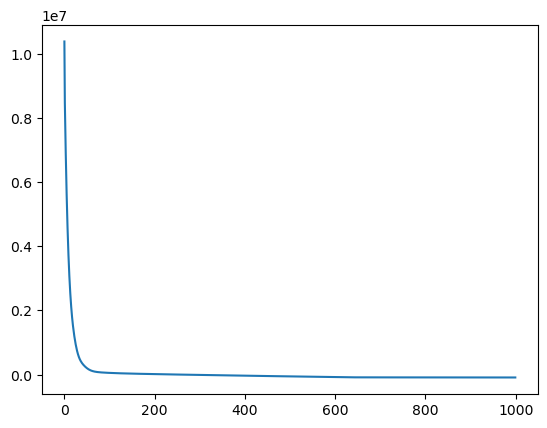

In [21]:
gpdm.init_X()  
losses = gpdm.train_adam(num_opt_steps=1000, num_print_steps=10, lr=0.05)

gpdm.save(f'{gpdm_save_name}_config.pth', f'{gpdm_save_name}_state.pth')  

plt.plot(losses)

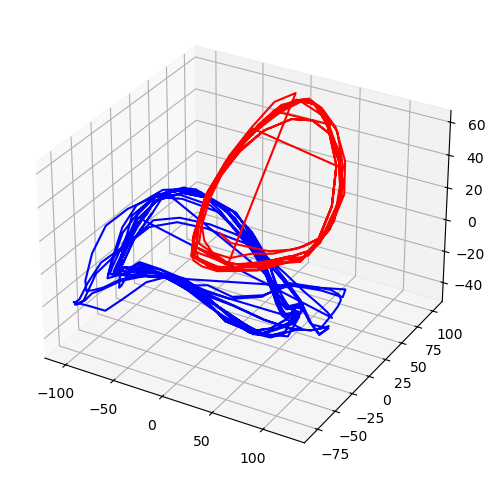

In [22]:
# Plot the latent space
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X0 = gpdm.get_X_for_class(0).detach().numpy()
X1 = gpdm.get_X_for_class(1).detach().numpy()

# plot X0 in blue and X1 in red
ax.plot(X0[:, 0], X0[:, 1], X0[:, 2], 'b')
ax.plot(X1[:, 0], X1[:, 1], X1[:, 2], 'r')

plt.show()